# Creating a Choropleth Map of the World in Python using Basemap

A choropleth map is a kind of a thematic map that can be used to display data that varies across geographic regions. Data values are usually mapped to different color saturations for numerical variables or color hues for categorical variables. Different patterns can also be used, but that is not as common. Typical examples are maps that show election results.

There are different approaches on how to create such a map in Python. In this notebook I'll show how you can use the [Matplotlib Basemap Toolkit](http://matplotlib.org/basemap/) to create a choropleth map of the world. The data that will be plotted shows forest area as a percentage of land area in 2012 [provided by the World Bank](http://data.worldbank.org/indicator/AG.LND.FRST.ZS/).

## Setup

There is no *choropleth for humans* package in Python, so this task is not as straightforward as other things in Python, but it isn't too bad either.

In addition to the data on forest area we need a shapefile with country borders to draw the map. I downloaded the *Admin 0 - Countries* with lakes from [Natural Earth Data](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and simplified it a bit with the following command:

    ogr2ogr -simplify .05 -lco ENCODING=UTF-8 countries/ ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp
    
This step is optional and only for speeding up processing a bit. To run this command you need to install the [GDAL library](http://www.gdal.org/).

Now let's get started with the actual Python code. First load the necessary modules and specify the files for input and output, set the number of colors to use and meta information about what is displayed.

In [1]:
%load_ext signature
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from geonamescache import GeonamesCache
from helpers import slug
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

filename = 'csv/ag.lnd.frst.zs_Indicator_en_csv_v2/ag.lnd.frst.zs_Indicator_en_csv_v2.csv'
shapefile = 'shp/countries/ne_10m_admin_0_countries_lakes'
num_colors = 9
year = '2012'
cols = ['Country Name', 'Country Code', year]
title = 'Forest area as percentage of land area in {}'.format(year)
imgfile = 'img/{}.png'.format(slug(title))

description = '''
Forest area is land under natural or planted stands of trees of at least 5 meters in situ, whether productive or not, and excludes tree stands in agricultural production systems (for example, in fruit plantations
and agroforestry systems) and trees in urban parks and gardens. Countries without data are shown in grey. Data: World Bank - worldbank.org • Author: Ramiro Gómez - ramiro.org'''.strip()

To identify countries we can use the 3-letter iso code, that is contained in both the World Bank data and the shapefiles. Since the World Bank dataset also lists regions that are not countries, like North America or Africa we want to filter out these non-country regions. To get a list of country iso codes we can use the [geonamescache](https://pypi.python.org/pypi/geonamescache) package as shown below.

In [2]:
gc = GeonamesCache()
iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

Next we read the dataset in a DataFrame set the `Country Code` as the index and keep only countries that are in the previously created list. We also drop missing values.

In [3]:
df = pd.read_csv(filename, skiprows=4, usecols=cols)
df.set_index('Country Code', inplace=True)
df = df.ix[iso3_codes].dropna() # Filter out non-countries and missing values.

To map data values to colors we can take advantage of Matplotlib's [colormap API](http://matplotlib.org/api/cm_api.html). We create a color scheme of 9 different saturations of green from light to dark, map the forest area values to the 9 color bins, and add a `bin` column to the DataFrame that can later be used to set the color value.

In [4]:
values = df[year]
cm = plt.get_cmap('Greens')
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
df['bin'] = np.digitize(values, bins) - 1 
df.sort_values('bin', ascending=False).head(10)

,Country Name,2012,bin
Country Code,,,
SUR,Suriname,94.556410,8
SYC,Seychelles,88.478261,7
ASM,American Samoa,88.200000,7
GAB,Gabon,85.380525,7
PLW,Palau,87.608696,7
BTN,Bhutan,85.804234,7
FSM,"Micronesia, Fed. Sts.",91.685714,7
SLB,Solomon Islands,78.663809,6
BRN,Brunei Darussalam,71.423150,6


## Plotting the map

To plot the map we first create a figure and a add subplot for the map itself. Then we create a Basemap instance setting the [Robinson projection](http://matplotlib.org/basemap/users/robin.html), that is used by the National Geographic Society for world maps.

Then we read the shapefile and iterate through the information contained within. The `ADM0_A3` field corresponds to the `Country Code` in the World Bank dataset and is used to identify the correct color bin to use. If there is no data for a country it is colored in a light grey instead.

The coloring is achieved by creating a [PatchColection](http://matplotlib.org/api/collections_api.html?highlight=patchcollection#matplotlib.collections.PatchCollection) from the shape information, setting its facecolor and adding the patch collection to the current axis object.

We also add a horizontal span covering up most of Antarctica, since there is no data to display and it takes up a considerable amount of space. Then we add another axis object for the map legend, placing it above that horizontal span, add the description of the map at the bottom and save the file.

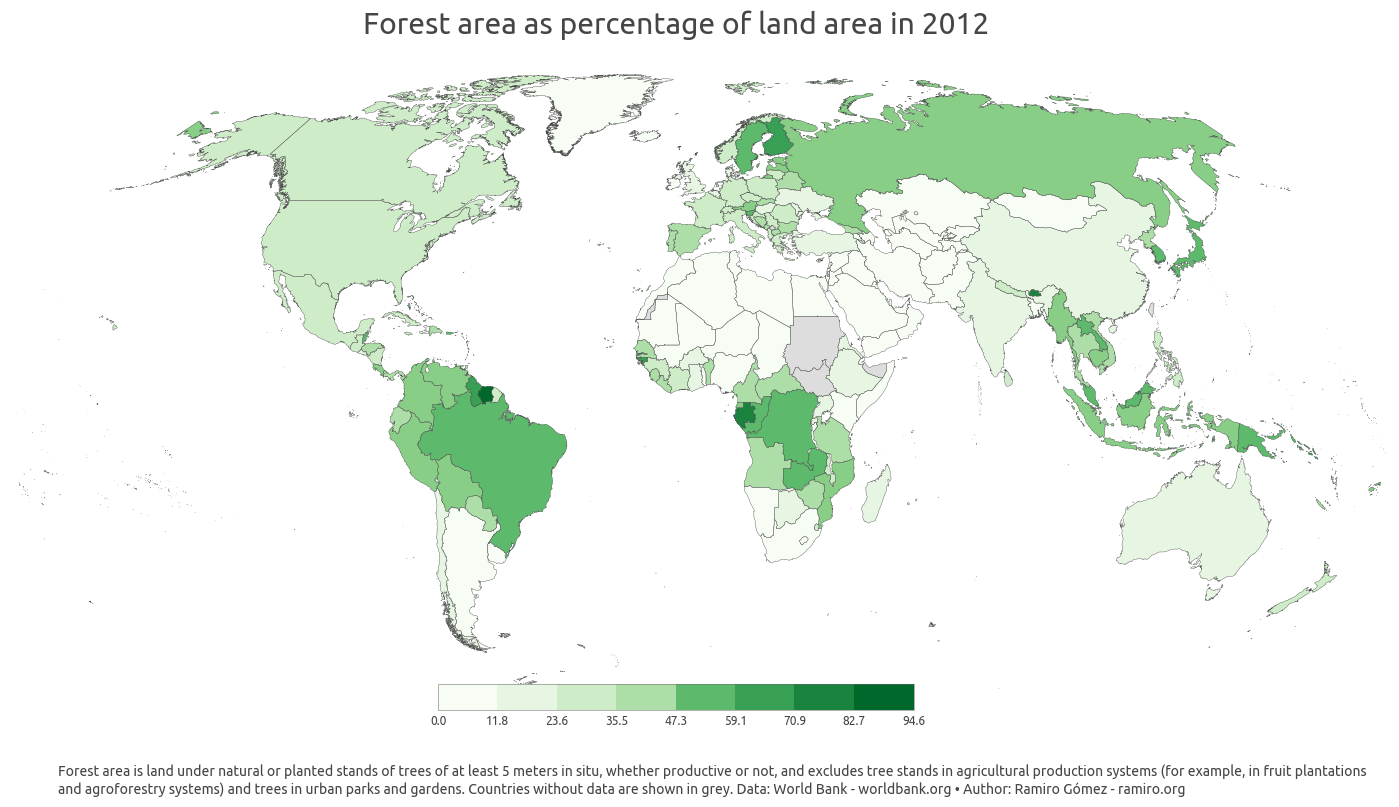

In [5]:
mpl.style.use('map')
fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.suptitle('Forest area as percentage of land area in {}'.format(year), fontsize=30, y=.95)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')

m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in df.index:
        color = '#dddddd'
    else:
        color = scheme[df.ix[iso3]['bin']]
    
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
    
# Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# Set the map footer.
plt.annotate(description, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)

## Summary

Compared to creating other basic chart types like bar or line charts using Matplotlib, choropleth maps are somewhat involving. I've previously used D3 for these kinds of maps and created the [d3.geopmap library](https://d3-geomap.github.io/) to reduce the amount of boilerplate code. 

D3 offers a wider range of [map projections](https://github.com/mbostock/d3/wiki/Geo-Projections) than Basemap, including Albers USA, which is the best choice for US states and county maps I know of, see [this map](http://maps.ramiro.org/map/usa/physically-inactive/) for an example. Also it is quite easy to add interactivity and zoom behaviour to aid data exploration.

On the other hand a static graphic like this one created with Basemap will load and render faster, especially on mobile devices, and it works in older browsers. Both approaches have its pros and cons and it doesn't hurt to be able to use different tools for similar tasks.

In [6]:
%signature